In [1]:
import geopandas as gpd
import os
import json
import pandas as pd
import tqdm
import math
import numpy as np
import seaborn as sns
from shapely import wkt
import matplotlib.pyplot as plt
import math
import re

In [2]:
plt.rcParams.update({'font.size': 13})
plt.rcParams.update({'axes.titlesize': 13})
plt.rcParams.update({'axes.labelsize': 13})
# size of the numbers on the axes
plt.rcParams.update({'xtick.labelsize': 9})
plt.rcParams.update({'ytick.labelsize': 9})
colors = sns.color_palette('husl', 10)

# Input data

Maria Parajeles from PSL provides the original EV data. Four different predicted EV charging pattern data in 2050 are available. CP is the predicted hourly charging load, PD is the hourly upper power bound, and PU is the hourly lower power bound. FE is the daily flexible charging energy, the sum of allowed deviation from controlled CP to actual CP in data. For CP, PD, and PU, each row is a municipality, and every column corresponds to each hour in the year. For FE, each row is a municipality, and every column corresponds to each day of the year. For these data, 4 steps are done to process the data. 

In [3]:
base_path = os.getcwd()
data_path = os.path.join(base_path, 'EV_input')

In [4]:
# read the municipalities
zones = gpd.read_file(os.path.join(data_path, 'nine_zones.geojson'))

In [5]:
# read the original data
CP = pd.read_csv(os.path.join(data_path, 'CP_y4.csv'), header=None)
FE = pd.read_csv(os.path.join(data_path, 'FE_y4.csv'), header=None)
PD = pd.read_csv(os.path.join(data_path, 'PD_y4.csv'), header=None)
PU = pd.read_csv(os.path.join(data_path, 'PU_y4.csv'), header=None)

# Step 1： BFS number mapping

Since in the EV data provided, the municipalities are represented by names, which is inconsistent with the naming convention for the grids. To improve the data processing efficiency, the BFS number was used to substitute the actual municipality name, following the mapping rules in `nine_zones.geojson`. During the mapping process, we found no EV data for three municipalities: Comunanza Cadenazzo/Monteceneri, Staatswald Galm, and Comunanza Capriasca/Lugano. 

In [6]:
# check if the first column of CP FE PD PU is the same
print('the columns of CP and FE are the same:', all(CP[0]==FE[0]))
print('the columns of CP and PD are the same:', all(CP[0]==PD[0]))
print('the columns of CP and PU are the same:', all(CP[0]==PU[0]))

the columns of CP and FE are the same: True
the columns of CP and PD are the same: True
the columns of CP and PU are the same: True


In [7]:
# print the municipalities that appear in zones file but not in CP file
print('Municipalities that appear in zones file but not in EV file: ', set(zones['NAME']) - set(CP[0]))
print('Municipalities that appear EV file but not in zones file: ', set(CP[0]) - set(zones['NAME']))

Municipalities that appear in zones file but not in EV file:  {'Staatswald Galm', 'Comunanza Cadenazzo/Monteceneri', 'Comunanza Capriasca/Lugano'}
Municipalities that appear EV file but not in zones file:  set()


In [8]:
# This function maps zone names in the input data to their corresponding BFS numbers 
# based on a provided zones mapping, ensuring data integrity and reordering columns.
# - It copies the input data to avoid modifying the original.
# - Maps the 'BFS_NUMMER' using the 'NAME' column of the zones DataFrame.
# - Removes the original zone name column, reorders columns, renames 'BFS_NUMMER' to 'BFS', 
#   converts it to integer type, and sorts the data by BFS.
# - Warns the user if there are any NaN values in the resulting BFS column.
# Returns a cleaned and mapped DataFrame.

def map_BFS(data, zones):
    df = data.copy()
    # Maps the 'BFS_NUMMER' using the 'NAME' column of the zones DataFrame.
    df['BFS_NUMMER'] = zones.set_index('NAME').loc[df[0].values].BFS_NUMMER.values
    # The name column, which is column 0, is removed
    df = df.drop(columns=[0])
    # The columns of the dataframe are reodered, such that the BFS_NUMMER column is the first column, followed by the rest of the columns.
    # The following columns are sorted in ascending order according to the time they represent.
    df = df[['BFS_NUMMER'] + [col for col in df.columns if col != 'BFS_NUMMER']]
    # The BFS_NUMMER column is renamed to BFS and converted to integer type.
    df.rename(columns={'BFS_NUMMER': 'BFS'}, inplace=True)
    df['BFS'] = df['BFS'].astype('int')
    # The dataframe is sorted by BFS number in ascending order and the index is reset.
    df = df.sort_values('BFS')
    df.reset_index(drop=True, inplace=True)
    # Sanity check for NaN values in the BFS column.
    if df['BFS'].isna().sum() > 0:
        print('There are NaN values in the BFS_NUMMER column')
    return df

# The BFS numbers are mapped to the input data, to assign the municipalities to the correct zones.
CP_mapped = map_BFS(CP, zones)
FE_mapped = map_BFS(FE, zones)
PD_mapped = map_BFS(PD, zones)
PU_mapped = map_BFS(PU, zones)

EV penetration rates

- 2020: 1.5 %
- 2030: 15 %
- 2040: 60 %
- 2050: 100 %
 

These are based on the Zero A scenario of the Energie Perspective of 2050+ for the Swiss Federal Office of Energy. And calibrated to fit the number of vehicles electrified in 2050 from my dataset. The reference is: Prognos AG, INFRAS AG, TEP Energy GmbH, Ecoplan AG, “Energieperspektiven 2050+ Kurzbericht” (Swiss Federal Office of Energy, Bern, 2020).

In [9]:
penetration_rates = {'2030': 0.15, '2040': 0.6, '2050': 1.0}

In [10]:
base_save_path = os.path.join(base_path, 'EV_output', 'EV_profiles')  

# We sum the consumption of the CP profile for every week of the year to get the total consumption per municipality.
# As CP has 8760 hours, we have to sum every 168 hours to get the weekly consumption.
CP_mapped_values = CP_mapped.drop(columns='BFS').values
CP_weekly = np.array([CP_mapped_values[:,i*168:(i+1)*168].sum(axis=1) for i in range(52)]).T

# we generate one file with PD_mapped, PU_mapped, and CP_mapped
# As all the three have the same BFS numbers and columns, we concatenate them and assign a new column name with "Upper", "Lower", and "Base". "Upper" corresponds to PU, "Lower" corresponds to PD, and "Base" corresponds to CP.
PU_mapped.insert(1, 'Type', 'Upper')
PD_mapped.insert(1, 'Type', 'Lower')
CP_mapped.insert(1, 'Type', 'Base')
Power_mapped = pd.concat([PU_mapped, PD_mapped, CP_mapped])
Power_mapped.sort_values('BFS', inplace=True)
Power_mapped.reset_index(drop=True, inplace=True)

Power_by_year = {year: Power_mapped.copy() for year in penetration_rates.keys()}
for year, penetration_rate in penetration_rates.items():
    Power_by_year[year][list(range(1,8761))] = Power_by_year[year][list(range(1,8761))].multiply(penetration_rate)
    Power_by_year[year][list(range(1,8761))] = Power_by_year[year][list(range(1,8761))].round(2)
    Power_by_year[year].to_csv(os.path.join(base_save_path, f'EV_power_profiles_LV_{year}.csv'), index=False)

FE_by_year = {year: FE_mapped.copy() for year in penetration_rates.keys()}
for year, penetration_rate in penetration_rates.items():
    FE_by_year[year][list(range(1,366))] = FE_by_year[year][list(range(1,366))].multiply(penetration_rate)
    FE_by_year[year][list(range(1,366))] = FE_by_year[year][list(range(1,366))].round(2)
    FE_by_year[year].to_csv(os.path.join(base_save_path, f'EV_flexible_energy_profiles_LV_{year}.csv'), index=False)

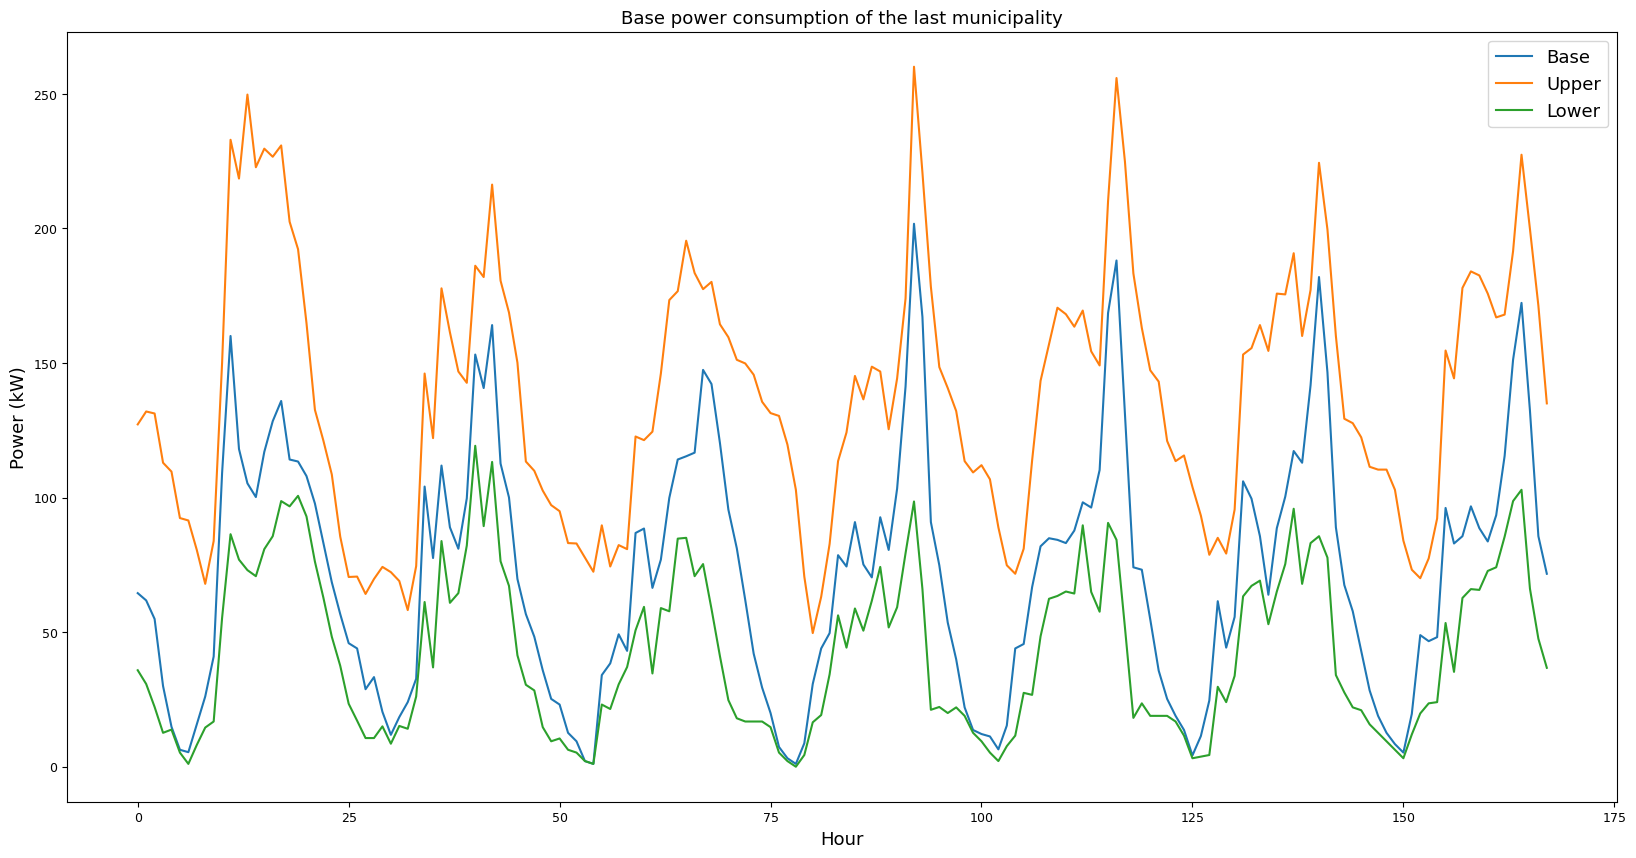

In [11]:
# We plot the profiles of the first municipality (BFS = 1) for the year 2030 for the first week.
example_base = Power_by_year['2030'][(Power_by_year['2030']['BFS'] == 1) & (Power_by_year['2030']['Type'] == 'Base')].iloc[:, 2:170].values.copy()
example_upper = Power_by_year['2030'][(Power_by_year['2030']['BFS'] == 1) & (Power_by_year['2030']['Type'] == 'Upper')].iloc[:, 2:170].values.copy()
example_lower = Power_by_year['2030'][(Power_by_year['2030']['BFS'] == 1) & (Power_by_year['2030']['Type'] == 'Lower')].iloc[:, 2:170].values.copy()

plt.figure(figsize=(20, 10))
plt.plot(example_base.flatten(), label = 'Base')
plt.plot(example_upper.flatten(), label = 'Upper')
plt.plot(example_lower.flatten(), label = 'Lower')
plt.xlabel('Hour')
plt.ylabel('Power (kW)')
plt.title('Base power consumption of the last municipality')
plt.legend()
plt.show()

# Step 2: Load allocation
Consider that the EV power consumption is distributed proportionately to the conventional load of the LV nodes in the given municipalities. Get the maximum value of CP (base EV consumption) and PD (upper EV power consumption).\
With these values, obtain the nodal distribution of maximum CP consumption and maximum PD consumption.  Get statistical descriptors of these distributions for the municipalities. 

All EV consumption is assumed to be supplied by LV grids. Within each municipality, consumption is allocated proportionally based on the conventional demand share at each node. Importantly, the allocation is only done for grids with edge files. For example, Municipality 715 contains only one grid with a single node without an edge. To prevent extreme allocation scenarios, grids with only one node are excluded from the allocation process, and the EV consumption for Municipality 715 is disregarded.

For instance, in Municipality 1, with 5 grids and a total of 818 nodes, the demand share for each node is calculated using Eq. (1), where $i$ represents the node index, $j$ represents the BFS number of the municipality and $t$ represents time step. Subsequently, the CP value for each node is determined using Eq. (2). The same approach applies to other parameters, such as PD, PU, FE, and EP.

\begin{equation}
    \text{share}_{ij} = \frac{\text{dmd}_{ij}}{\sum_{i=1}^N \text{dmd}_{ij}} \tag{1}
\end{equation}

\begin{equation}
    \text{CPshare}_{ijt} = CP_{jt} \cdot \text{share}_{ij} \tag{2}
\end{equation}

In [ ]:
# Function: concat_all_grids
# **Description**:
# This function aggregates node-level data for a set of grids, calculating the demand (`el_dmd`) 
# and its percentage contribution relative to the total demand across all grids.

# **Arguments**:
# - `grid_ids` (list): A list of grid IDs to process. Each ID represents a grid, and IDs without an underscore are skipped.
# - `path` (str): The directory path where node files for each grid are located. Each node file is expected to be a GeoDataFrame.

# **Returns**:
# - `node_total` (pd.DataFrame): A DataFrame containing the following columns:
#   - `grid_name`: The name of the grid.
#   - `node_name`: The node identifier (from the 'osmid' column).
#   - `dmd`: The demand at the node (from the 'el_dmd' column, defaulted to 0 if missing).
#   - `percentage`: The percentage of the node's demand relative to the total demand across all nodes in all grids.
# - If no valid grids are found, an empty DataFrame is returned.

# **Additional Notes**:
# - For grids missing the 'osmid' column, the function skips processing.
# - The `el_dmd` column is initialized to zero for grids where it is not present.
# - The function prints a message when encountering single-node grids or empty grids.

def concat_all_grids(grid_ids, path):
    node_total_list = []
    for n in range(len(grid_ids)):
        node_id = grid_ids[n]+"_nodes"
        node = gpd.read_file(path+node_id)
        if 'el_dmd' not in node.columns:
            node['el_dmd'] = 0
        dmd = node['el_dmd']
        if 'osmid' not in node.columns:
            continue    
        node_name = node['osmid']
        node_total_list.append(pd.DataFrame({'grid_name':grid_ids[n], 'node_name':node_name, 'dmd':dmd}))
    if len(node_total_list) == 0:
        return pd.DataFrame()
    node_total = pd.concat(node_total_list, ignore_index=True)
    node_total['dmd'] = node_total['dmd'].astype(float)
    node_total['percentage'] = node_total['dmd']/node_total['dmd'].sum()
    return node_total

The dataframe `node_total` has the conventional load information of the LV nodes contained within a given municipality. The percentage of the conventional load that they consume in the given municipality is assigned to a column named 'percentage'. This percentage is scaled by the maximum CP, PU and PD in the municipality profiles. Their results are stored in 'CP_max', 'PU_max', and 'PD_max'.

In addition, `statistics` has statistics about the EV load assigned to each grid. The columns of the file are:
- 'BFS': The BFS number, which indicates the municipality.
- 'median': The median conventional load percentage that nodes with consumption have, i.e., nodes with load above 0.
- 'deviation': The standard deviation of conventional load percentage that nodes with consumption have, i.e., nodes with load above 0.
- '90th quantile': The 90th quantile of load percentage.
- '95th quantile': The 90th quantile of load percentage.
- '99th quantile': The 90th quantile of load percentage.
- 'CP_max': The sum of the maximum base EV power consumption for the nodes contained in the grid. 
- 'PU_max': The sum of the maximum upper EV power consumption for the nodes contained in the grid. 
- 'max_percentage': maximum nodal percentage of the total conventional load of the municipality.
- 'min_percentage': minimum nodal percentage of the total conventional load of the municipality.

In [21]:
mother_path = os.path.dirname(base_path)
LV_data_path = os.path.join(mother_path, 'LV/')
dict_path = os.path.join(mother_path, 'data_processing')
save_path = os.path.join(base_path, 'EV_output','EV_percentage')

with open(os.path.join(dict_path, 'dict_folder.json')) as f:    
    dictionary = json.load(f)
len_dict = len(dictionary)
keys = list(dictionary.keys())

statistics_list = []

CP_max_values = pd.Series(CP_mapped.iloc[:,2:].max(axis=1).values, index=CP_mapped['BFS'])
PU_max_values = pd.Series(PU_mapped.iloc[:,2:].max(axis=1).values, index=PU_mapped['BFS'])
PD_max_values = pd.Series(PD_mapped.iloc[:,2:].max(axis=1).values, index=PD_mapped['BFS'])
node_profiles_list = []


for key in tqdm.tqdm(keys):
    path = LV_data_path+dictionary[key]+'/'
    grid_ids = list(set([f[:-6] for f in os.listdir(path) if f.startswith(key+'-')]))
    node_total = concat_all_grids(grid_ids,path)
    if node_total.empty:
        print('Empty grid:', key)
        continue
    node_total_test = node_total[node_total['dmd']>0]
    CP_max = CP_max_values.loc[int(key)]
    PU_max = PU_max_values.loc[int(key)]
    PD_max = PD_max_values.loc[int(key)]
    
    statistics_list.append(pd.DataFrame({'BFS':key, 
                                                      'median':node_total_test['percentage'].median(), 
                                                      'deviation':node_total_test['percentage'].std(),
                                                        '90th quantile':node_total_test['percentage'].quantile(0.9),
                                                        '95th quantile':node_total_test['percentage'].quantile(0.95),
                                                        '99th quantile':node_total_test['percentage'].quantile(0.99),
                                                        'CP_max':CP_max,
                                                        'PU_max':PU_max,
                                                        'max_percentage':node_total['percentage'].max(),
                                                        'min_percentage':node_total['percentage'].min()}, index=[0]))
    
    node_total['CP_max'] = CP_max*node_total['percentage']
    node_total['PU_max'] = PU_max*node_total['percentage']
    node_total['PD_max'] = PD_max*node_total['percentage']
    node_total['BFS'] = int(key)
    node_profiles_list.append(node_total)

node_profiles = pd.concat(node_profiles_list, ignore_index=True)
node_profiles['grid_name'] = node_profiles['grid_name'].astype(str)
node_profiles['node_name'] = node_profiles['node_name'].astype(str)
node_profiles.sort_values(['BFS','grid_name','node_name'], ascending=True, inplace=True)
node_profiles.to_parquet(os.path.join(save_path, 'node_profiles.parquet'))
node_profiles_reduced = node_profiles[['grid_name', 'node_name', 'percentage']].copy()
node_profiles_reduced.to_csv(os.path.join(save_path, 'EV_allocation_LV.csv'), index=False)
statistics = pd.concat(statistics_list, ignore_index=True)
statistics.to_csv(save_path+'/statistics.csv', index=False)

100%|██████████| 2148/2148 [09:31<00:00,  3.76it/s] 


# Step 3: Distribution analysis

high deviation: the percentages allocated to modes are imbalance
high CP_max: the maximum power consumption in this grid is much higher than other grid.

After allocating EV consumption to LV grids, we analyzed the statistical distribution of consumption per node and per grid across nine zones, categorized as periurban, rural, and urban areas within the Alps, Jura, and Midlands regions.

In [22]:
def hist_in_zone(data, zone, zone_municipality):
    zone_name = zone
    zone_data = zone_municipality[zone_municipality['zone']==zone_name].copy()
    zone_data['municipality'] = zone_data['municipality'].astype('int')
    zone_muni = zone_data['municipality'].values
    data = data[data['BFS'].isin(zone_muni)].copy()
    data.reset_index(drop=True, inplace=True)
    return data

In [23]:
zone_municipality_list = []
for key in dictionary.keys():
    zone = dictionary[key]
    municipality = key
    zone_municipality_list.append(pd.DataFrame({'zone':zone, 'municipality':municipality}, index=[0]))
zone_municipality = pd.concat(zone_municipality_list, ignore_index=True)

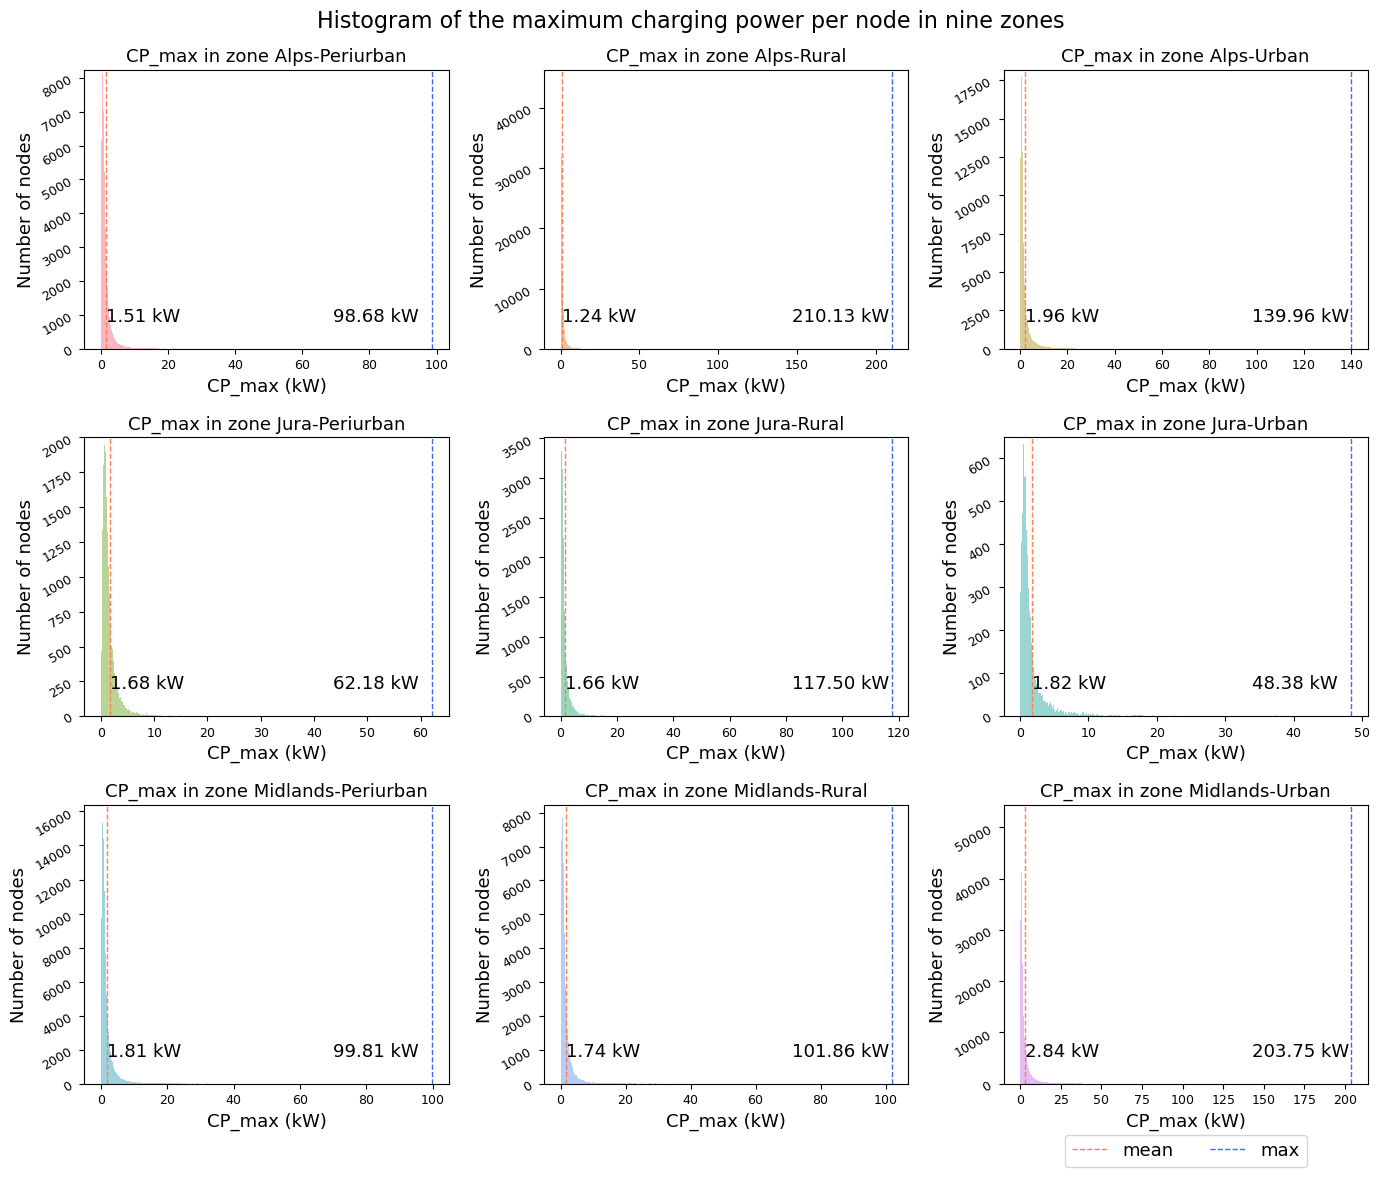

In [24]:
# we rename the column '9_CAT' to 'zone'
zones.rename(columns={'9_CAT':'zone'}, inplace=True)
unique_zones = zones['zone'].unique()

data_nodes = pd.read_parquet(save_path+'/node_profiles.parquet')

# data to look at
column = 'CP_max'

plt.figure(figsize=(14, 12))
unique_zones.sort()
for i in range(len(unique_zones)):
    zone = unique_zones[i]
    data = hist_in_zone(data_nodes, zone, zone_municipality)
    data = data[data[column]>0]
    plt.subplot(3, 3, i+1)
    counts, bins, patches = plt.hist(data[column], bins=1200, alpha=0.5,  color=colors[i])
    mean = data[column].mean()
    plt.axvline(mean, color='coral', linestyle='dashed', linewidth=1, label='mean')
    
    max = data[column].max()
    plt.axvline(max, color='royalblue', linestyle='dashed', linewidth=1, label='max')
    plt.xlabel(f'{column} (kW)')
    plt.ylabel('Number of nodes')
    # get the max count of the histogram
    max_count = counts.max()
    plt.ylim(0, max_count*1.01)
    plt.text(0.7*max, 0.1*max_count, f'{max:.2f} kW', rotation=0)
    plt.text(mean, 0.1*max_count, f'{mean:.2f} kW', rotation=0)
    plt.title(f'{column} in zone {zone}')
    # rotate y ticks
    plt.yticks(rotation=30)
# put the legend outside the plot, under the x-axis, and remove the frame, in the middle of the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.suptitle('Histogram of the maximum charging power per node in nine zones', fontsize=16)
plt.tight_layout()  
if not os.path.exists(os.path.join(base_path, 'plots')):
    os.makedirs(os.path.join(base_path, 'plots'))
plt.savefig(os.path.join(base_path, 'plots', f'{column}_histogram.png'), dpi = 300, bbox_inches='tight')  
plt.show()

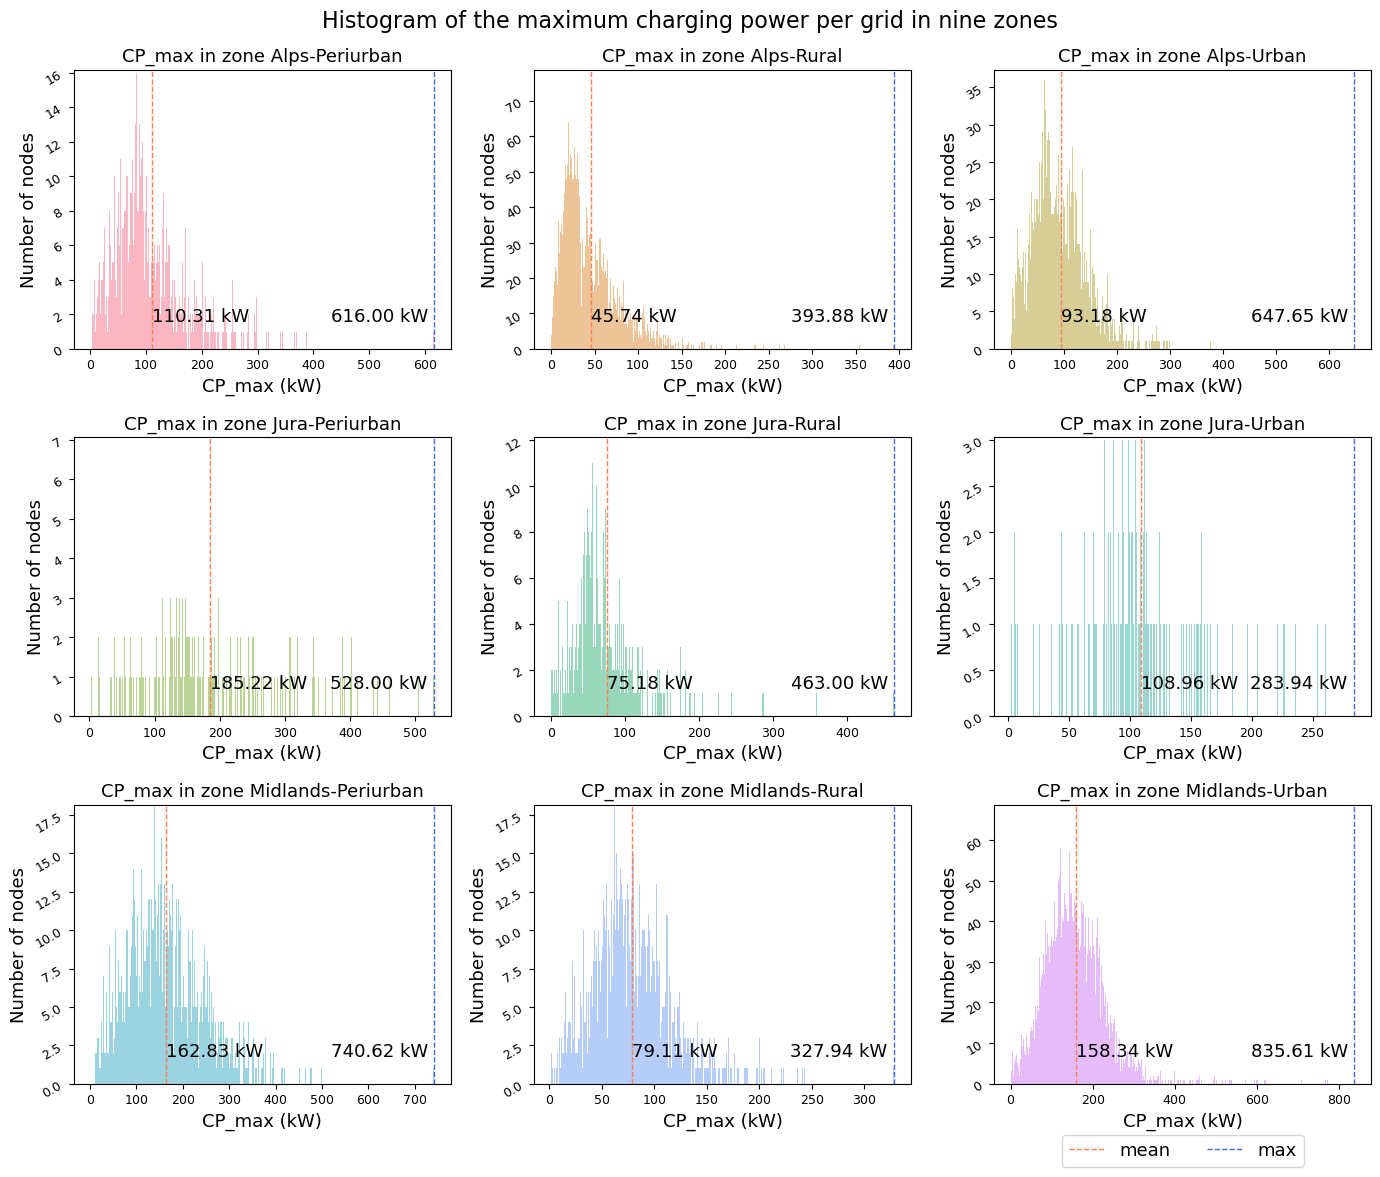

In [25]:
plt.figure(figsize=(14, 12))
for i in range(len(unique_zones)):
    zone = unique_zones[i]
    data = hist_in_zone(data_nodes, zone, zone_municipality)
    # group by grid_name, delete node_name
    data = data.drop(columns=['node_name']).groupby('grid_name').sum()
    data.reset_index(inplace=True)
    
    plt.subplot(3, 3, i+1)
    counts, bins, patches = plt.hist(data[column], bins=1200, alpha=0.5,  color=colors[i])
    mean = data[column].mean()
    plt.axvline(mean, color='coral', linestyle='dashed', linewidth=1, label='mean')
    
    max = data[column].max()
    plt.axvline(max, color='royalblue', linestyle='dashed', linewidth=1, label='max')
    plt.xlabel(f'{column} (kW)')
    plt.ylabel('Number of nodes')

    max_count = counts.max()
    plt.ylim(0, max_count*1.01)
    plt.text(0.7*max, 0.1*max_count, f'{max:.2f} kW', rotation=0)
    plt.text(mean, 0.1*max_count, f'{mean:.2f} kW', rotation=0)
    plt.title(f'{column} in zone {zone}')
    plt.yticks(rotation=30)
# put the legend outside the plot, under the x-axis, and remove the frame, in the middle of the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.suptitle('Histogram of the maximum charging power per grid in nine zones', fontsize=16)
plt.tight_layout()  
plt.savefig(os.path.join(base_path, 'plots', f'{column}_histogram_grid.png'), dpi = 300, bbox_inches='tight')
plt.show()

In [26]:
zone_types = ['Alps-Periurban', 'Alps-Rural', 'Alps-Urban', 'Midlands-Periurban', 'Midlands-Rural', 'Midlands-Urban', 'Jura-Periurban', 'Jura-Rural', 'Jura-Urban']
name_files = []
for type_zone in zone_types:
    grid_zone_path = os.path.join(os.path.dirname(os.getcwd()), 'LV/', type_zone)
    # we obtain the file names in the folder
    files = os.listdir(grid_zone_path)
    grid_ids = [name.replace('_edges', '') for name in files if 'edges' in name]
    name_files += grid_ids

grids_in_EV = node_profiles.grid_name.unique()
# we check if the grids in the EV data are in the LV data
check_grids = [name for name in name_files if not(name in grids_in_EV)]

print('Grids without allocated EV profiles :', len([name for name in name_files if not(name in grids_in_EV)]))

Grids without allocated EV profiles : 0


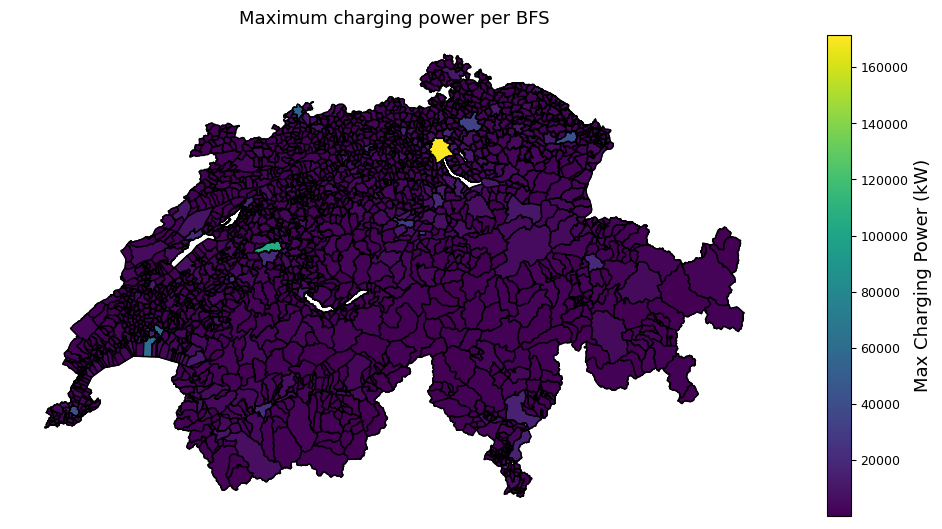

In [27]:
# We plot the max CP per BFS
# To do so, we get the max CP per BFS with node_profiles.groupby('BFS')['CP_max'].sum()
# The geometry of the zones is in zones['geometry'] and the BFS number is in zones['BFS_NUMMER']
# We create a geodataframe with the max CP per BFS and the geometry of the zones

max_CP_per_BFS = node_profiles.groupby('BFS')['CP_max'].sum().reset_index()
max_CP_per_BFS.rename(columns={'CP_max':'max_CP'}, inplace=True)
max_CP_per_BFS['BFS'] = max_CP_per_BFS['BFS'].astype('int')
max_CP_per_BFS = max_CP_per_BFS.merge(zones[['BFS_NUMMER', 'geometry']], left_on='BFS', right_on='BFS_NUMMER')
max_CP_per_BFS = gpd.GeoDataFrame(max_CP_per_BFS)
max_CP_per_BFS.crs = zones.crs

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
zones.plot(ax=ax, color='lightgrey', edgecolor='black')
max_CP_per_BFS.plot(
    ax=ax, column='max_CP', cmap='viridis', edgecolor='black', legend=True,
    legend_kwds={'shrink': 0.5, 'label': 'Max Charging Power (kW)'}  # Adjust shrink factor to make the colorbar smaller
)
plt.title('Maximum charging power per BFS')
plt.axis('off')
plt.tight_layout()
plt.show()